Author: Satendra Yadav


### Import libraries

In [4]:
import os
import numpy as np
from PIL import Image
import seaborn as sns
import subprocess as sp
import matplotlib.pyplot as plt
from collections import Counter

### Set paths

In [5]:
path = 'Data/emotion_classification/'
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

### Load files

In [6]:
train_files = sp.getoutput(f'ls {train_path} | grep .gif').split("\n")
test_files = sp.getoutput(f'ls {test_path} | grep .gif').split("\n")

In [7]:
train_files = [os.path.join(train_path, f_name) for f_name in train_files]
test_files = [os.path.join(test_path, f_name) for f_name in test_files]

### Extract labels for data

In [8]:
train_y = np.array([1 if 'happy' in f_name else 0 for f_name in train_files])
test_y = np.array([1 if 'happy' in f_name else 0 for f_name in test_files])


### Create feature matrix

In [9]:
train_x = np.stack([np.array(Image.open(f_name)).reshape(-1) for f_name in train_files])
test_x = np.stack([np.array(Image.open(f_name)).reshape(-1) for f_name in test_files])


### Mean normalization

In [10]:
mean = train_x.mean(axis=0)
train_x = train_x - mean
test_x = test_x - mean

### Computing the PCA components

In [11]:
# we will use SVD decomposition to extract the principal components
# A = U S Vt
# columns of matrix V are the eigen(here right singular) vectors of the covariance matrix.
# The vectors are already sorted according to their values
U, S, Vt = np.linalg.svd(train_x, full_matrices=True)

In [12]:
# eigen values are
S ** 2

array([8.13518673e+07, 3.93221461e+07, 3.24692516e+07, 1.93360217e+07,
       1.53448924e+07, 1.48530491e+07, 1.25407327e+07, 1.00795877e+07,
       7.86345772e+06, 7.54817924e+06, 6.45100542e+06, 6.26153115e+06,
       4.74969176e+06, 4.23894861e+06, 3.60987178e+06, 3.39283628e+06,
       2.89195650e+06, 2.46185219e+06, 1.73952015e+06, 5.78946906e-24])

As there are only 20 singular values we can restrict the value of K to be used for LDA to lie in the range 1 to 20

In [13]:
# PCA components
components = Vt.T

### Setting the value of K

In [14]:
# we will perform this for only a single value of K
# it is expected that you can modify the code
# by introducing helper functions, to run
# the analysis for other different values
K = 16

In [15]:
pca_k_train_x = np.matmul(train_x, components[: , :K])
pca_k_test_x = np.matmul(test_x, components[: , :K])

In [16]:
pca_k_train_x.shape, pca_k_test_x.shape

array([[-5201.09637131, -1514.31966279,    62.3638011 ,  1518.82640326,
         -166.37442961,  1337.37648971,  1075.96591831,  -404.67248369,
          813.43301963,  -802.79051535,    75.21768345,  -103.12141265,
          -12.19801064,   116.13297134,  -128.89723226,   -79.63185501],
       [  814.20480483, -1705.65188506,  -852.30242028, -1296.08072841,
         1257.19753867,   496.46553016,   131.30847756, -1020.58733772,
          -83.99403429,   604.12281305,  -900.49581481,  -389.63985853,
          360.48846133,   312.07986213,   -46.50783128,  -265.48220801],
       [  211.08888696, -1012.64850542,   -59.17845159,  -465.71623094,
         1420.73456925,  -581.80367995,   446.08630891,   175.4611775 ,
          -21.91426729,    36.69435999,  -656.54244965,  -301.30790838,
          376.93250923,   285.1659284 ,  -136.63575473,   278.6203517 ],
       [-3240.18555858,  -995.57130442,  -369.11282874,   457.18923468,
          -79.05846631,  -136.42160773,  -154.980039  ,   705

### Performing LDA

In [17]:
# class means
M0 = pca_k_train_x[train_y == 0].mean(axis=0)
M1 = pca_k_train_x[train_y == 1].mean(axis=0)

In [18]:
# between class scatter matrix
S_b = np.outer((M1 - M0), (M1 - M0).T)

In [19]:
# within class scatter matrix
S_w = np.zeros_like(S_b)
for i, sample in enumerate(pca_k_train_x):
    if train_y[i] == 0:
        S_w = S_w + np.outer((sample - M0), (sample - M0).T)
    else:
        S_w = S_w + np.outer((sample - M1), (sample - M1).T)

In [20]:
'''The following is a slightly different approach for finding the projection vector'''
# for linear projection constants don't make a difference, so
# W = lambda (inv(S_w) @ S_b @ W)
# S_b @ W = (M1 - M0) @ (M1 - M0).T @ W = k (M1 - M0), where k = (m1 - m0)
# Thus, W = inv(S_w) @ (M1 - M0)
W = np.matmul(np.linalg.inv(S_w), (M1 - M0).reshape(-1, 1))

### LDA Transformation

In [21]:
lda_train_x = np.matmul(pca_k_train_x, W).reshape(-1)
lda_test_x = np.matmul(pca_k_test_x, W).reshape(-1)

### Finding Threshold

In [22]:
# find max and min value for the projected value of each class
max_0, min_0 = np.max(lda_train_x[train_y == 0]), np.min(lda_train_x[train_y == 0])
max_1, min_1 = np.max(lda_train_x[train_y == 1]), np.min(lda_train_x[train_y == 1])

In [23]:
# maximum separability threshold - heuristic
threshold_start, threshold_end = min(max_0, max_1), max(min_0, min_1)
optimal_threshold = (threshold_start + threshold_end) / 2
# threshold value after multiple runs with different values of K
# can be seen to be closer to 0. 
# Using optimal_threshold = 0 is thus a better choice than using the
# above heuristic

### Visualize the separation for train and test set

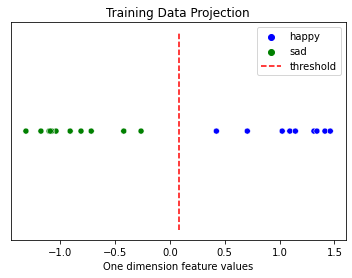

In [24]:
sns.scatterplot(x=lda_train_x, y=[0]*len(train_y), hue=['happy' if s_class == 1 else 'sad' for s_class in train_y], palette=['blue', 'green'])
plt.vlines(optimal_threshold, -1, 1, colors='r', linestyles='--', label='threshold')
plt.xlabel('One dimension feature values')
plt.yticks([])
plt.title('Training Data Projection')
plt.legend()
plt.show()

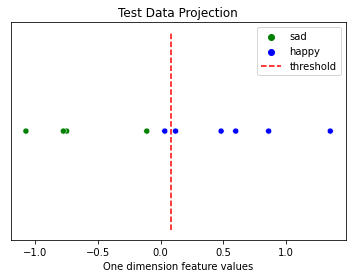

In [25]:
sns.scatterplot(x=lda_test_x, y=[0]*len(test_y), hue=['happy' if s_class == 1 else 'sad' for s_class in test_y], palette=['green', 'blue'])
plt.vlines(optimal_threshold, -1, 1, colors='r', linestyles='--', label='threshold')
plt.xlabel('One dimension feature values')
plt.yticks([])
plt.title('Test Data Projection')
plt.legend()
plt.show()

### Accuracy on test set

In [26]:
# find which side of the threshold majority of a particular label resides
class_1_train_labels = Counter([1 if sample_class >= optimal_threshold else -1
                                    for sample_class in lda_train_x[train_y == 1]])
class_1_majority = class_1_train_labels.most_common()[0][0]

In [27]:
class_1_majority

1

In [28]:
classification_test_labels = [1 if class_1_majority * sample_class >= class_1_majority * optimal_threshold else 0 
                                  for sample_class in lda_test_x]
accuracy = sum([yhat == y for yhat, y in zip(classification_test_labels, test_y)]) / len(test_y) * 100
accuracy

90.0

### Separability measure

In [29]:
J = ((W.T @ S_b @ W) / (W.T @ S_w @ W))[0, 0]
J

2.0044757846726653